## Fork

세 변수 ${X, Y, Z}$는 변수 $Z$가 변수 $X$와 변수 $Y$의 직접적인 원인일 때 **분기(fork)** 를 형성한다 (그림 참조). 만약 연구자가 $Y$를 $X$의 함수로 모델링하고자 한다면, $Z$는 **교란 변수(confounding variable)** 라고 한다. 
이는 $Z$의 $X$와 $Y$에 대한 영향을 통제하지 않으면, $X$가 $Y$에 미치는 효과의 추정이 편향되기 때문이다. 확률 분포 $P$가 주어졌을 때, 그림 13에 나타난 분기 과정에 대해 베이지안 네트워크 분해(Bayesian network factorization)를 적용하면 다음과 같은 결과를 얻는다.

$$
P[X,Y,Z]=P[Z]P[X|Z]P[Y|Z]
$$  

이는 $X$와 $Y$ 사이에 (비인과적) 연관성이 존재함을 의미한다. 이는 다음과 같은 식으로 나타난다.

$$
P[X,Y]=\sum_{Z}P[Z]P[X|Z]P[Y|Z]\neq P[X]P[Y].
$$  

이는 비인과적 연관성의 예로, $X$와 $Y$ 사이에 인과 경로가 없음에도 불구하고 **뒷문 경로(backdoor path)** 인 $Y \leftarrow Z \rightarrow X$을 통해 두 변수가 연관되어 있기 때문이다. 변수 $Z$로 조건부화하는 것은 뒷문 경로를 차단하므로, 이는 **do-calculus** 을 시뮬레이션한 것과 동일하며, 그 결과로 $X$와 $Y$는 조건부 독립을 갖게 된다.

$$
P[X,Y|Z]=\frac{P[X,Y,Z]}{P[Z]}=P[X|Z]P[Y|Z].
$$  


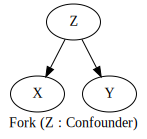

In [1]:
import graphviz as gr

fork = gr.Digraph(
    'G',
    node_attr = {'shape': 'ellipse'}, 
    graph_attr = {'label': 'Fork (Z : Confounder)'}
)

fork.edge('Z', 'X')
fork.edge('Z', 'Y')

fork

이 인과 그래프에서 변수 $Z$로 조건부화하면 $P[X, Y]$가 교란되지 않게(de-confound) 되지만, 다른 인과 그래프에서는 그렇지 않을 수 있다. 현상에 관련된 모든 변수를 조건부화(혹은 통제)해야 한다는 계량경제학자들의 일반적인 개념은 오해를 불러일으킬 수 있다(6.4.2.2절 참조). 정확한 **교란 제거 변수(de-confounding variable)** 는 **do-calculus rules**에 의해 결정된다(4.3.2절 참조). 위의 결론은 다음 수치 실험을 통해 검증할 수 있다.

먼저, 다음과 같은 구조 방정식 모델로 정의된 데이터 생성 과정을 통해 5,000개의 관측값을 추출한다.

$$
\begin{array}{r l}&{Z_{t}:=\xi_{t}}\\ &{X_{t}:=Z_{t}+\epsilon_{t}}\\ &{Y_{t}:=Z_{t}+\zeta_{t}}\end{array}
$$  

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

np.random.seed(42) # set random seed

In [3]:
z = np.random.normal(size = 5000) # observable confounder
x = z + np.random.normal(size = z.shape[0]) # false cause
y = z + np.random.normal(size = z.shape[0]) # false effect

여기서 ${\xi_{t}, \epsilon_{t}, \zeta_{t}}$는 표준 정규분포를 따르는 독립 랜덤 변수들이다. 이후, 이 5,000개의 관측값에 대해 다음 선형 방정식을 적합시킨다.

$$
Y_{t}=\alpha+\beta X_{t}+\varepsilon_{t}.
$$  

In [4]:
# Incorrect estimate of X -> Y
ols0 = sm.OLS(
    y, sm.add_constant(x)
).fit()

In [5]:
print(ols0.summary(xname = ['const','X'], yname = 'Y')) # false positive

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.242
Model:                            OLS   Adj. R-squared:                  0.242
Method:                 Least Squares   F-statistic:                     1595.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):          5.83e-303
Time:                        13:16:05   Log-Likelihood:                -8115.8
No. Observations:                5000   AIC:                         1.624e+04
Df Residuals:                    4998   BIC:                         1.625e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0182      0.017      1.051      0.2

연구자가 OLS 모형을 통해 적합화한 인과적 내용에 따라, 통계적으로 유의미한 $\hat{\boldsymbol{\beta}}$는 "$X$가 $Y$를 유발한다"는 진술을 의미하며, "$X$가 $Y$와 관련되어 있다"는 진술을 의미하지 않는다(5.2절 참조). 만약 연구자가 연관성을 입증하고자 했다면, 피어슨 상관계수나 **직교 회귀(orthogonal regression)** 와 같은 연관성 모델을 사용했어야 한다(5.1절 참조). 그러나 그림 13은 $X$에서 $Y$로의 인과 경로가 존재하지 않음을 보여준다. 따라서 통계적 유의미성에 대한 주장은 **type-B spurious** 에 해당하는데, 이는 모델 명세에 따라 $Y$가 $X$의 함수가 아니기 때문이다. 이와 같은 오류는 하나의 교란 변수(confounder)를 누락한 결과이다.

6.4.2.1절에서 설명한 바와 같이, $Z$를 회귀식의 독립 변수로 추가함으로써 교란 변수로 인한 편향을 제거할 수 있다(부분 상관관계 방법). 이 경우, 다음과 같은 수정된 모델을 사용한다.

$$
Y_{t}=\alpha+\beta X_{t}+\gamma Z_{t}+\varepsilon_{t}
$$  

In [6]:
# Correct estimate of X -> Y
X = np.column_stack((x, z))
ols1 = sm.OLS(
    y, sm.add_constant(X)
).fit()

아래의 표은 이 조정의 결과를 보여준다. 올바른 모형을 사용하면 연구자는 $X$가 $Y$를 유발하지 않는다는 결론에 도달하게 된다.

In [7]:
print(ols1.summary(xname = ['const','X','Z'], yname = 'Y')) # true negative

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.497
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     2473.
Date:                Wed, 30 Oct 2024   Prob (F-statistic):               0.00
Time:                        13:16:05   Log-Likelihood:                -7087.9
No. Observations:                5000   AIC:                         1.418e+04
Df Residuals:                    4997   BIC:                         1.420e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0105      0.014      0.744      0.4